This `HTML` tag, used in a `Jupyter Notebook` cell, hides all error messages (standard error output) in the notebook by setting their display style to 'none'. It targets div elements with the class `output_stderr`, which are used to show error outputs. Source: https://stackoverflow.com/questions/58275372/how-do-i-make-a-div-set-to-style-display-none-by-default

In [1]:
%%html
<style>
    div.output_stderr { display: none; }
</style>                               

In [2]:
# Importing needed packages.

import time          # Built-in, no version.
import keras         # Version 2.14.0.
import numpy as np   # Version 1.26.4.
import pandas as pd  # Version 2.2.1.
from datetime import datetime        # Built-in, no version.
from keras.layers import Dense       # Version 2.14.0.
import matplotlib.pyplot as plt      #Version 3.5.1.
from keras.models import Sequential  # Version 2.14.0.
from pyspark.sql import SparkSession # Version 3.4.2.
from tensorflow.keras.optimizers import Adam  # Version 2.14.0
from sklearn.model_selection import train_test_split  # Version 1.4.1.post1
from sklearn.preprocessing import LabelEncoder, StandardScaler   # Version 1.4.1.post1 

2024-04-03 19:25:57.963850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 19:25:58.297227: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 19:25:58.297363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 19:25:58.298741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 19:25:58.481874: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 19:25:58.484295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
start_time = time.time()
# Create SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config('spark.driver.memory', '5g') \
    .appName('HDFS_Data_to_model_NN') \
    .getOrCreate()

# Read CSV file from HDFS
path = 'hdfs:///CA1_S2/people_increased.csv'  # Use 'hdfs://' prefix to indicate HDFS path
df = spark.read.option('inferSchema', 'true').option('header', 'true').csv(path)

# Show DataFrame schema
df.printSchema()

# Show first few rows of DataFrame
df.show()

24/04/03 19:26:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- Index: integer (nullable = true)
 |-- User_Id: string (nullable = true)
 |-- First_Name: string (nullable = true)
 |-- Last_Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Phone: string (nullable = true)
 |-- DOB: date (nullable = true)
 |-- Job_Title: string (nullable = true)

+-----+---------------+----------+---------+------+--------------------+--------------------+----------+--------------------+
|Index|        User_Id|First_Name|Last_Name|Gender|               Email|               Phone|       DOB|           Job_Title|
+-----+---------------+----------+---------+------+--------------------+--------------------+----------+--------------------+
|    1|4defE49671cF860|    Sydney|  Shannon|  Male|   tvang@example.net|   574-440-1423x9799|2020-07-09|    Technical brewer|
|    2|F89B87bCf8f210b|    Regina|      Lin|  Male| helen14@example.net|001-273-664-2268x...|1909-06-20|Teacher, adult ed...|
|    3|Cad6052BDd5

In [4]:
row_count = df.count()
print(f"The DataFrame has {row_count} rows.")

The DataFrame has 14000000 rows.


In [5]:
# Dropping duplicates based on User_Id
df = df.dropDuplicates(['User_Id'])

In [6]:
row_count = df.count()
print(f"The DataFrame has {row_count} rows.")

The DataFrame has 2000000 rows.


In [7]:
# Convert the Spark DataFrame to a Pandas DataFrame
df= df.toPandas()

# Sorting the df
df = df.sort_values(by='Index', ascending=True).reset_index()

df = df.drop('index', axis=1)

end_time = time.time()

# Display pd df
df

,Index,User_Id,First_Name,Last_Name,Gender,Email,Phone,DOB,Job_Title
0,1,4defE49671cF860,Sydney,Shannon,Male,tvang@example.net,574-440-1423x9799,2020-07-09,Technical brewer
1,2,F89B87bCf8f210b,Regina,Lin,Male,helen14@example.net,001-273-664-2268x90121,1909-06-20,"Teacher, adult education"
2,3,Cad6052BDd5DEaf,Pamela,Blake,Female,brent05@example.org,927-880-5785x85266,1964-08-19,Armed forces operational officer
3,4,e83E46f80f629CD,Dave,Hoffman,Female,munozcraig@example.org,001-147-429-8340x608,2009-02-19,Ship broker
4,5,60AAc4DcaBcE3b6,Ian,Campos,Female,brownevelyn@example.net,166-126-4390,1997-10-02,Media planner
...,...,...,...,...,...,...,...,...,...
1999995,1999996,AbBE4F3Eb5df843,Susan,Ellison,Male,yward@example.net,855.222.4135x62040,1913-01-05,Research scientist (maths)
1999996,1999997,e71af3E8De63CDF,Cole,Sherman,Female,nbarnett@example.org,(130)829-9159x800,1977-04-15,Marketing executive
1999997,1999998,fAF0618097acD1B,Ethan,Leonard,Male,brett57@example.com,514.898.2376x3069,1960-08-14,Photographer
1999998,1999999,f1FC3346F68DFAb,Jordan,Waller,Female,harveykendra@example.com,6920274656,1911-09-05,Chartered accountant


In [8]:
execution_time = end_time - start_time
# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)
print(f"Total execution time: {minutes} minutes {seconds} seconds") # Usually it takes 2 minutes 41 seconds

Total execution time: 2 minutes 43 seconds


In [9]:
# Calculating ppl age.
df['DOB'] = pd.to_datetime(df['DOB'])
df['Age'] = df['DOB'].apply(lambda x: datetime.now().year - x.year)

In [10]:
# Encoding "Sex" as binary values
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])  # Male will be 1, Female will be 0

In [11]:
# Selecting only needed columns
# Dropping columns except 'Sex', 'Date of birth', and 'Job Title'
df = df[['Gender', 'Job_Title','Age']]

# Renaming the column 'Job Title' to 'Job_Title'
df = df.rename(columns={'Job Title': 'Job_Title'})

df = df.reset_index(drop=True).rename_axis(None, axis=1)

df.head()

,Gender,Job_Title,Age
0,1,Technical brewer,4
1,1,"Teacher, adult education",115
2,0,Armed forces operational officer,60
3,0,Ship broker,15
4,0,Media planner,27


In [12]:
# Creating df1 to optimise NN
df1 = df.copy()

In [13]:
X = df.iloc[:,1:] # selecting all columns except Gender| Dependent variables
y = df.iloc[:,0] # selecting Gender as our target variable | Independent variable

In [14]:
# Encoding "Job_Title"
encoder = LabelEncoder()
X['Job_Title'] = encoder.fit_transform(X['Job_Title'])  # Each job will have a number assigned 0, 1, 2....

In [15]:
X.head()

,Job_Title,Age
0,592,4
1,584,115
2,45,60
3,544,15
4,369,27


In [16]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: Gender, dtype: int64

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
model = Sequential()
model.add(Dense(12,input_dim=2,activation='relu')) # First layer
model.add(Dense(8,activation='relu')) # Second layer
model.add(Dense(1,activation='sigmoid'))

In [19]:
# Compile the model
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

In [20]:
# Train the model
start_time = time.time()
history = model.fit(X, y, epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100


2024-04-03 19:28:55.120668: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-04-03 19:28:55.283782: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-04-03 19:28:55.291419: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-04-03 19:28:55.841813: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2024-04-03 19:28:55.848301: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.


3907/3907 - 5s - loss: 0.6934 - accuracy: 0.5001 - 5s/epoch - 1ms/step
Epoch 2/100
3907/3907 - 4s - loss: 0.6932 - accuracy: 0.4999 - 4s/epoch - 996us/step
Epoch 3/100
3907/3907 - 4s - loss: 0.6932 - accuracy: 0.5007 - 4s/epoch - 1ms/step
Epoch 4/100
3907/3907 - 4s - loss: 0.6932 - accuracy: 0.5004 - 4s/epoch - 1ms/step
Epoch 5/100
3907/3907 - 4s - loss: 0.6932 - accuracy: 0.5001 - 4s/epoch - 1ms/step
Epoch 6/100
3907/3907 - 4s - loss: 0.6932 - accuracy: 0.5003 - 4s/epoch - 993us/step
Epoch 7/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.5003 - 4s/epoch - 964us/step
Epoch 8/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.4995 - 4s/epoch - 995us/step
Epoch 9/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.4996 - 4s/epoch - 1ms/step
Epoch 10/100
3907/3907 - 4s - loss: 0.6932 - accuracy: 0.5004 - 4s/epoch - 971us/step
Epoch 11/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.5000 - 4s/epoch - 971us/step
Epoch 12/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.4999 - 4s/epoch - 1ms/step
E

Epoch 98/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.4995 - 4s/epoch - 962us/step
Epoch 99/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.5004 - 4s/epoch - 984us/step
Epoch 100/100
3907/3907 - 4s - loss: 0.6931 - accuracy: 0.5004 - 4s/epoch - 950us/step


In [21]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 6 minutes 44 seconds


In [22]:
# Convert history.history dict to a pandas DataFrame
history_df = pd.DataFrame(history.history)

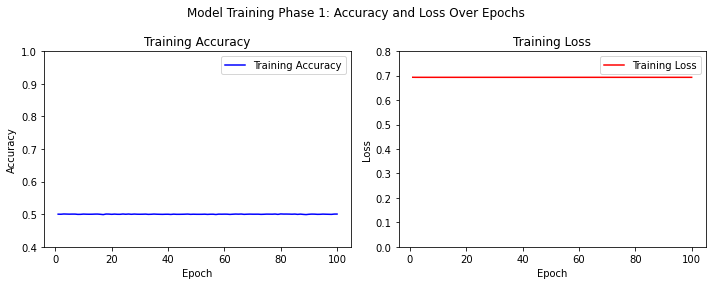

In [23]:
# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(.4, 1)  # Set the y-axis limits for accuracy
plt.legend()

plt.suptitle("Model Training Phase 1: Accuracy and Loss Over Epochs")

plt.subplot(1, 2, 2)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.8) # Set the y-axis limits for loss
plt.legend()

plt.tight_layout()
plt.show()

## The NN is clearly not performing well. Let's treat each job as a feature and transpose them into columns, filling each column with the Age.

In [24]:
df1.head()

,Gender,Job_Title,Age
0,1,Technical brewer,4
1,1,"Teacher, adult education",115
2,0,Armed forces operational officer,60
3,0,Ship broker,15
4,0,Media planner,27


In [25]:
#df1 = df2.copy()

In [26]:
df2 = df1.copy()

In [27]:
# Add a unique identifier for each row within each group of 'Sex' and 'Job_Title'
df1['unique_id'] = df1.groupby(['Gender', 'Job_Title']).cumcount()

# Pivot the table, using 'Sex' and 'unique_id' as the index
df1 = df1.pivot_table(index=['Gender', 'unique_id'], columns='Job_Title', values='Age').reset_index()
df1  = df1.rename_axis(None, axis=1) # Index with no name as it should be

# Drop the 'unique_id' column as it's no longer needed, keeping 'Sex'
df1.drop('unique_id', axis=1, inplace=True)

# Display the result
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3385,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3386,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3387,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df1 = df1.dropna()

In [29]:
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,1,23.0,38.0,86.0,36.0,6.0,61.0,53.0,70.0,80.0,...,82.0,87.0,72.0,100.0,35.0,18.0,22.0,86.0,71.0,92.0
3134,1,23.0,78.0,43.0,65.0,109.0,33.0,109.0,94.0,76.0,...,93.0,22.0,107.0,25.0,87.0,108.0,16.0,19.0,47.0,81.0
3135,1,18.0,61.0,93.0,33.0,23.0,6.0,104.0,91.0,36.0,...,31.0,81.0,24.0,81.0,112.0,78.0,26.0,43.0,97.0,12.0
3136,1,60.0,59.0,75.0,55.0,3.0,87.0,50.0,71.0,98.0,...,101.0,118.0,103.0,88.0,88.0,18.0,67.0,29.0,22.0,86.0


In [30]:
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,1,23.0,38.0,86.0,36.0,6.0,61.0,53.0,70.0,80.0,...,82.0,87.0,72.0,100.0,35.0,18.0,22.0,86.0,71.0,92.0
3134,1,23.0,78.0,43.0,65.0,109.0,33.0,109.0,94.0,76.0,...,93.0,22.0,107.0,25.0,87.0,108.0,16.0,19.0,47.0,81.0
3135,1,18.0,61.0,93.0,33.0,23.0,6.0,104.0,91.0,36.0,...,31.0,81.0,24.0,81.0,112.0,78.0,26.0,43.0,97.0,12.0
3136,1,60.0,59.0,75.0,55.0,3.0,87.0,50.0,71.0,98.0,...,101.0,118.0,103.0,88.0,88.0,18.0,67.0,29.0,22.0,86.0


In [31]:
X = df1.iloc[:,1:] # selecting all columns except Gender | Dependent variable
y = df1.iloc[:,0] # selecting column Gender as our target variable | Independent variable

In [32]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
model = Sequential()
model.add(Dense(12,input_dim=639,activation='relu')) # First layer
model.add(Dense(8,activation='relu')) # Second layer
model.add(Dense(1,activation='sigmoid'))

In [34]:
# Compile the model
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

In [35]:
# Train the model
start_time = time.time()
history = model.fit(X, y, epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100
6/6 - 0s - loss: 0.7476 - accuracy: 0.4991 - 478ms/epoch - 80ms/step
Epoch 2/100
6/6 - 0s - loss: 0.7026 - accuracy: 0.5473 - 41ms/epoch - 7ms/step
Epoch 3/100
6/6 - 0s - loss: 0.6718 - accuracy: 0.5865 - 44ms/epoch - 7ms/step
Epoch 4/100
6/6 - 0s - loss: 0.6475 - accuracy: 0.6189 - 37ms/epoch - 6ms/step
Epoch 5/100
6/6 - 0s - loss: 0.6265 - accuracy: 0.6546 - 31ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.6087 - accuracy: 0.6804 - 40ms/epoch - 7ms/step
Epoch 7/100
6/6 - 0s - loss: 0.5917 - accuracy: 0.7083 - 32ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.5754 - accuracy: 0.7317 - 32ms/epoch - 5ms/step
Epoch 9/100
6/6 - 0s - loss: 0.5596 - accuracy: 0.7499 - 25ms/epoch - 4ms/step
Epoch 10/100
6/6 - 0s - loss: 0.5439 - accuracy: 0.7678 - 30ms/epoch - 5ms/step
Epoch 11/100
6/6 - 0s - loss: 0.5285 - accuracy: 0.7833 - 28ms/epoch - 5ms/step
Epoch 12/100
6/6 - 0s - loss: 0.5131 - accuracy: 0.7967 - 23ms/epoch - 4ms/step
Epoch 13/100
6/6 - 0s - loss: 0.4974 - accuracy

In [36]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 0 minutes 4 seconds


In [37]:
# Converting history into a DataFrame
history_df1 = pd.DataFrame(history.history)

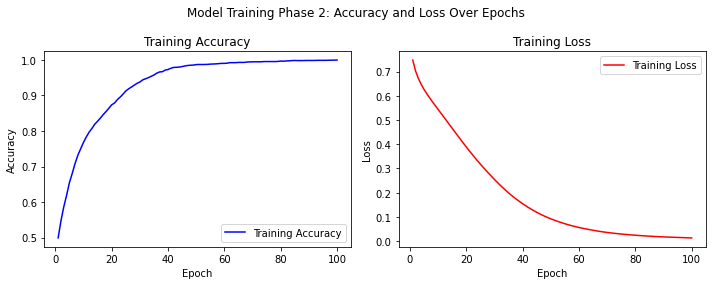

In [38]:
# Extracting epochs
epochs_range = np.array(range(1, len(history_df1) + 1))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df1['accuracy'].values, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle("Model Training Phase 2: Accuracy and Loss Over Epochs")

plt.subplot(1, 2, 2)
# Convert the Series to a numpy array
plt.plot(epochs_range, history_df1['loss'].values, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model seems overfitting, checking overfitting.

In [39]:
# Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(12, input_dim=639, activation='relu'))  # First layer
model.add(Dense(8, activation='relu'))  # Second layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100
5/5 - 1s - loss: 0.7921 - accuracy: 0.4968 - val_loss: 0.7742 - val_accuracy: 0.5086 - 853ms/epoch - 171ms/step
Epoch 2/100
5/5 - 0s - loss: 0.7426 - accuracy: 0.5135 - val_loss: 0.7584 - val_accuracy: 0.5069 - 93ms/epoch - 19ms/step
Epoch 3/100
5/5 - 0s - loss: 0.7077 - accuracy: 0.5265 - val_loss: 0.7460 - val_accuracy: 0.5034 - 83ms/epoch - 17ms/step
Epoch 4/100
5/5 - 0s - loss: 0.6818 - accuracy: 0.5531 - val_loss: 0.7363 - val_accuracy: 0.5241 - 82ms/epoch - 16ms/step
Epoch 5/100
5/5 - 0s - loss: 0.6607 - accuracy: 0.5841 - val_loss: 0.7299 - val_accuracy: 0.5223 - 73ms/epoch - 15ms/step
Epoch 6/100
5/5 - 0s - loss: 0.6435 - accuracy: 0.6155 - val_loss: 0.7257 - val_accuracy: 0.5103 - 57ms/epoch - 11ms/step
Epoch 7/100
5/5 - 0s - loss: 0.6288 - accuracy: 0.6452 - val_loss: 0.7230 - val_accuracy: 0.5069 - 56ms/epoch - 11ms/step
Epoch 8/100
5/5 - 0s - loss: 0.6154 - accuracy: 0.6787 - val_loss: 0.7218 - val_accuracy: 0.5155 - 53ms/epoch - 11ms/step
Epoch 9/100
5/5 - 0s -

Epoch 68/100
5/5 - 0s - loss: 0.0704 - accuracy: 0.9940 - val_loss: 1.3530 - val_accuracy: 0.5086 - 44ms/epoch - 9ms/step
Epoch 69/100
5/5 - 0s - loss: 0.0674 - accuracy: 0.9940 - val_loss: 1.3675 - val_accuracy: 0.5086 - 87ms/epoch - 17ms/step
Epoch 70/100
5/5 - 0s - loss: 0.0646 - accuracy: 0.9948 - val_loss: 1.3811 - val_accuracy: 0.5086 - 68ms/epoch - 14ms/step
Epoch 71/100
5/5 - 0s - loss: 0.0618 - accuracy: 0.9944 - val_loss: 1.3957 - val_accuracy: 0.5120 - 79ms/epoch - 16ms/step
Epoch 72/100
5/5 - 0s - loss: 0.0592 - accuracy: 0.9948 - val_loss: 1.4106 - val_accuracy: 0.5120 - 61ms/epoch - 12ms/step
Epoch 73/100
5/5 - 0s - loss: 0.0567 - accuracy: 0.9953 - val_loss: 1.4256 - val_accuracy: 0.5137 - 49ms/epoch - 10ms/step
Epoch 74/100
5/5 - 0s - loss: 0.0544 - accuracy: 0.9957 - val_loss: 1.4398 - val_accuracy: 0.5137 - 52ms/epoch - 10ms/step
Epoch 75/100
5/5 - 0s - loss: 0.0522 - accuracy: 0.9966 - val_loss: 1.4543 - val_accuracy: 0.5155 - 50ms/epoch - 10ms/step
Epoch 76/100
5/5 

In [40]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 0 minutes 7 seconds


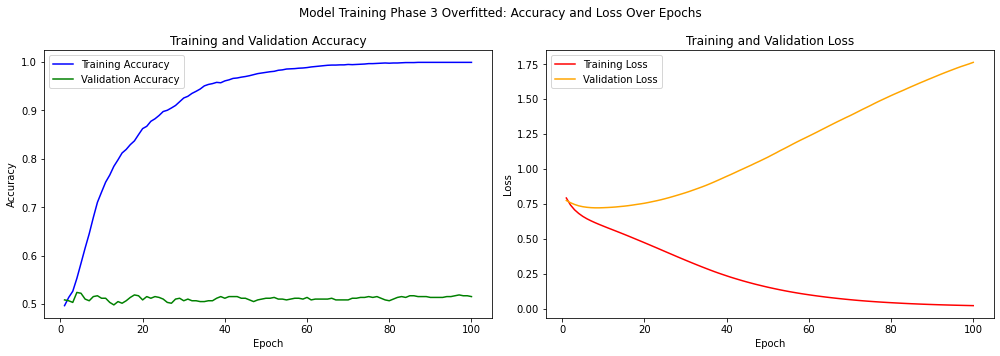

In [41]:

# Converting history into a DataFrame
history_df = pd.DataFrame(history.history)

# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))


# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.plot(epochs_range, history_df['val_accuracy'].values, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.plot(epochs_range, history_df['val_loss'].values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Model Training Phase 3 Overfitted: Accuracy and Loss Over Epochs")
plt.tight_layout()
plt.show()

## Training vs. Validation Performance

An overfitted model will perform well on the training data but poorly on unseen validation or test data. If the accuracy on the training data is **significantly higher** than on the validation data, it may be a sign of overfitting.

## Training Performance Over Time

If the accuracy continues to improve and the loss decreases over time on the training set but not on the validation set, it may indicate overfitting. We can clearly see that the model is overfitting; it performs well on training data but poorly on validation. A solution might be **adding more data to the model**.

## Adding data to the model for better performance

In [42]:
# Assuming `df` is your existing DataFrame
df1 = pd.concat([df1]*4, ignore_index=True)

In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11628 entries, 0 to 11627
Columns: 640 entries, Gender to Youth worker
dtypes: float64(639), int64(1)
memory usage: 56.8 MB


In [44]:
X = df1.iloc[:,1:] # selecting all columns except Gender | Dependent variable
y = df1.iloc[:,0] # selecting column Gender as our target variable | Independent variable

In [45]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [46]:
# Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(12, input_dim=639, activation='relu'))  # First layer
model.add(Dense(8, activation='relu'))  # Second layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=512, verbose=2)
end_time = time.time()

Epoch 1/100
19/19 - 1s - loss: 0.9240 - accuracy: 0.5158 - val_loss: 0.7776 - val_accuracy: 0.5469 - 745ms/epoch - 39ms/step
Epoch 2/100
19/19 - 0s - loss: 0.6994 - accuracy: 0.5946 - val_loss: 0.6727 - val_accuracy: 0.5937 - 140ms/epoch - 7ms/step
Epoch 3/100
19/19 - 0s - loss: 0.6107 - accuracy: 0.6697 - val_loss: 0.6197 - val_accuracy: 0.6599 - 115ms/epoch - 6ms/step
Epoch 4/100
19/19 - 0s - loss: 0.5595 - accuracy: 0.7361 - val_loss: 0.5850 - val_accuracy: 0.7042 - 118ms/epoch - 6ms/step
Epoch 5/100
19/19 - 0s - loss: 0.5195 - accuracy: 0.7796 - val_loss: 0.5547 - val_accuracy: 0.7322 - 265ms/epoch - 14ms/step
Epoch 6/100
19/19 - 0s - loss: 0.4847 - accuracy: 0.8149 - val_loss: 0.5273 - val_accuracy: 0.7640 - 139ms/epoch - 7ms/step
Epoch 7/100
19/19 - 0s - loss: 0.4523 - accuracy: 0.8462 - val_loss: 0.4998 - val_accuracy: 0.7962 - 99ms/epoch - 5ms/step
Epoch 8/100
19/19 - 0s - loss: 0.4211 - accuracy: 0.8688 - val_loss: 0.4735 - val_accuracy: 0.8130 - 134ms/epoch - 7ms/step
Epoch 9

Epoch 67/100
19/19 - 0s - loss: 0.0081 - accuracy: 0.9995 - val_loss: 0.0193 - val_accuracy: 0.9970 - 95ms/epoch - 5ms/step
Epoch 68/100
19/19 - 0s - loss: 0.0079 - accuracy: 0.9995 - val_loss: 0.0190 - val_accuracy: 0.9970 - 93ms/epoch - 5ms/step
Epoch 69/100
19/19 - 0s - loss: 0.0077 - accuracy: 0.9995 - val_loss: 0.0186 - val_accuracy: 0.9970 - 103ms/epoch - 5ms/step
Epoch 70/100
19/19 - 0s - loss: 0.0074 - accuracy: 0.9995 - val_loss: 0.0181 - val_accuracy: 0.9970 - 100ms/epoch - 5ms/step
Epoch 71/100
19/19 - 0s - loss: 0.0072 - accuracy: 0.9995 - val_loss: 0.0178 - val_accuracy: 0.9970 - 114ms/epoch - 6ms/step
Epoch 72/100
19/19 - 0s - loss: 0.0070 - accuracy: 0.9995 - val_loss: 0.0176 - val_accuracy: 0.9970 - 102ms/epoch - 5ms/step
Epoch 73/100
19/19 - 0s - loss: 0.0068 - accuracy: 0.9995 - val_loss: 0.0173 - val_accuracy: 0.9970 - 107ms/epoch - 6ms/step
Epoch 74/100
19/19 - 0s - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.0172 - val_accuracy: 0.9970 - 117ms/epoch - 6ms/step
Ep

In [47]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 0 minutes 12 seconds


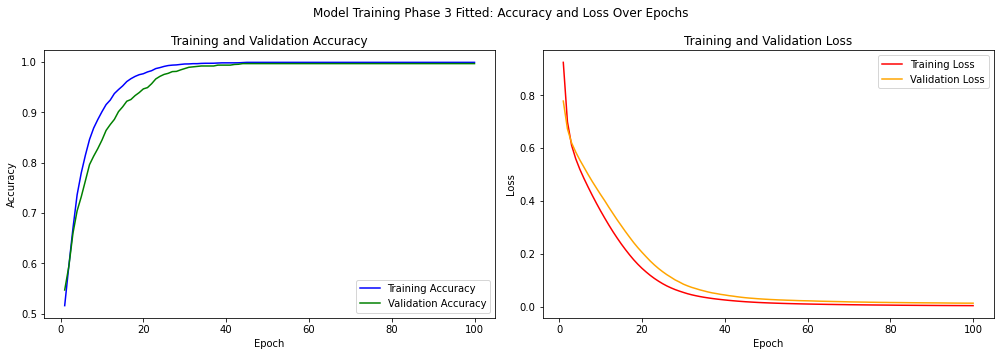

In [48]:
# Converting history into a DataFrame
history_df = pd.DataFrame(history.history)

# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))


# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.plot(epochs_range, history_df['val_accuracy'].values, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.plot(epochs_range, history_df['val_loss'].values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Model Training Phase 3 Fitted: Accuracy and Loss Over Epochs")
plt.tight_layout()
plt.show()

In [49]:
df1

,Gender,Academic librarian,Accommodation manager,"Accountant, chartered","Accountant, chartered certified","Accountant, chartered management","Accountant, chartered public finance",Accounting technician,Actor,Actuary,...,Volunteer coordinator,Warden/ranger,Warehouse manager,Waste management officer,Water engineer,Water quality scientist,Web designer,Wellsite geologist,Writer,Youth worker
0,0,3.0,8.0,54.0,40.0,41.0,35.0,100.0,5.0,77.0,...,17.0,21.0,4.0,44.0,96.0,78.0,112.0,3.0,78.0,6.0
1,0,74.0,35.0,40.0,67.0,74.0,55.0,60.0,6.0,34.0,...,19.0,96.0,74.0,52.0,59.0,114.0,100.0,35.0,87.0,76.0
2,0,114.0,86.0,22.0,102.0,86.0,99.0,95.0,118.0,15.0,...,118.0,23.0,52.0,42.0,110.0,45.0,5.0,86.0,15.0,50.0
3,0,25.0,32.0,37.0,44.0,97.0,92.0,110.0,34.0,7.0,...,15.0,45.0,20.0,44.0,84.0,90.0,31.0,54.0,63.0,3.0
4,0,53.0,16.0,60.0,27.0,57.0,60.0,77.0,70.0,40.0,...,65.0,21.0,112.0,64.0,94.0,56.0,83.0,94.0,104.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11623,1,23.0,38.0,86.0,36.0,6.0,61.0,53.0,70.0,80.0,...,82.0,87.0,72.0,100.0,35.0,18.0,22.0,86.0,71.0,92.0
11624,1,23.0,78.0,43.0,65.0,109.0,33.0,109.0,94.0,76.0,...,93.0,22.0,107.0,25.0,87.0,108.0,16.0,19.0,47.0,81.0
11625,1,18.0,61.0,93.0,33.0,23.0,6.0,104.0,91.0,36.0,...,31.0,81.0,24.0,81.0,112.0,78.0,26.0,43.0,97.0,12.0
11626,1,60.0,59.0,75.0,55.0,3.0,87.0,50.0,71.0,98.0,...,101.0,118.0,103.0,88.0,88.0,18.0,67.0,29.0,22.0,86.0


## Validation Loss Decreases Consistently
Both the training and validation losses are decreasing over the epochs, which indicates that the model is learning and generalizing well to unseen data.

## Close Training and Validation Accuracy
The training and validation accuracies are very close to each other and high, suggesting that the model performs similarly well on both the training set and the validation set. This is a good sign of generalization.

## Stable Performance Over Epochs
The accuracy reaches a high value and remains stable, which suggests that the model has learned the patterns in the data well without memorizing the training set.

Neural Network performance, with high accuracy on both the training and validation sets and decreasing loss over time, indicates effective learning without overfitting. The close alignment of training and validation metrics throughout training means a well-generalized model.

After adding data to the neural network, we can observe convergence between training and validation accuracy, as well as training and validation loss.